# 1. Imports

In [1]:
# scikit-learn
from sklearn import set_config # return pd.DataFrame from transformers
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, RobustScaler # scale to zero mean and unit variance
from sklearn.decomposition import PCA # primary component analysis
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# others
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plots
import numpy as np
import pickle # move transformers and estimators between notebooks

# custom helper functions
from helper_functions import explain_prediction, plot_decision_tree, generate_anomalies

<hr>

# 2. Settings

In [2]:
# set sklearn functions to output pd.DataFrames
set_config(transform_output='pandas')

# plot figures with higher resolutions
plt.rcParams['figure.dpi'] = 150

<hr>

# 3.Preprocessing

## 3.1 General Preprocessing

In [3]:
# read the data
df = pd.read_csv('./data/hcvdat33_Complete.csv', index_col=0) # use first col as index

In [4]:
# TODO: Decide, whether to drop Sex or not

# drop the index and the nominal feature 'sex'
df.drop(columns=['Sex'], inplace=True)

In [5]:
df

,Category,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...
611,3=Cirrhosis,62,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
612,3=Cirrhosis,64,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
613,3=Cirrhosis,64,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
614,3=Cirrhosis,46,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


In [6]:
# seperate features and label
X = df.drop(columns='Category')
y = df['Category']

In [7]:
# numerically encode labels whilst storing their names
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [8]:
# extract class names from label encoder
class_names = label_encoder.classes_
class_names = [class_name.split('=')[1] for class_name in class_names]
class_names = list(map(str, class_names)) # convert to list of strings

class_names

['Blood Donor', 'suspect Blood Donor', 'Hepatitis', 'Fibrosis', 'Cirrhosis']

In [9]:
# create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=42)

## 3.2 Missing Data

### 3.2.1 Inspection

In [10]:
# calculate the # of missing values per feature
X_missing = X.isnull().sum()

print("Missing Values per Feature:\n")
print(X_missing)

Missing Values per Feature:

Age      0
ALB      1
ALP     18
ALT      1
AST      0
BIL      0
CHE      0
CHOL    10
CREA     0
GGT      0
PROT     1
dtype: int64


### 3.2.2 Imputation

In [11]:
imputer = KNNImputer(n_neighbors=5, weights='distance') # initialize the imputer

## 3.3 Pipeline

In [12]:
# combine all transformers from preprocessing to pipeline
preprocessing = Pipeline(steps=[('imputation', imputer)])

<hr>

# 4.  Decision Tree Classifier

## 4.1 Training

In [13]:
# initialize the decision tree classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=5)

In [14]:
# encapsulate the decision tree in a pipeline
decision_tree = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('tree', clf)
    ])

In [15]:
# train the decision tree
#decision_tree.fit(X_train.values, y_train)
decision_tree.fit(X_train.values, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputation',
                                  KNNImputer(weights='distance'))])),
                ('tree', DecisionTreeClassifier(max_depth=5, random_state=42))])

## 4.2 Evaluation

In [16]:
# predict classes from the test set
y_pred = decision_tree.predict(X_test.values)

In [17]:
# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

In [18]:
# print summary
print(f'Using a depth of {clf.get_depth()}, the tree achieves {round(np.multiply(accuracy, 100), 2)} % accuracy ')

Using a depth of 5, the tree achieves 88.21 % accuracy 


## 4.3 Visualization

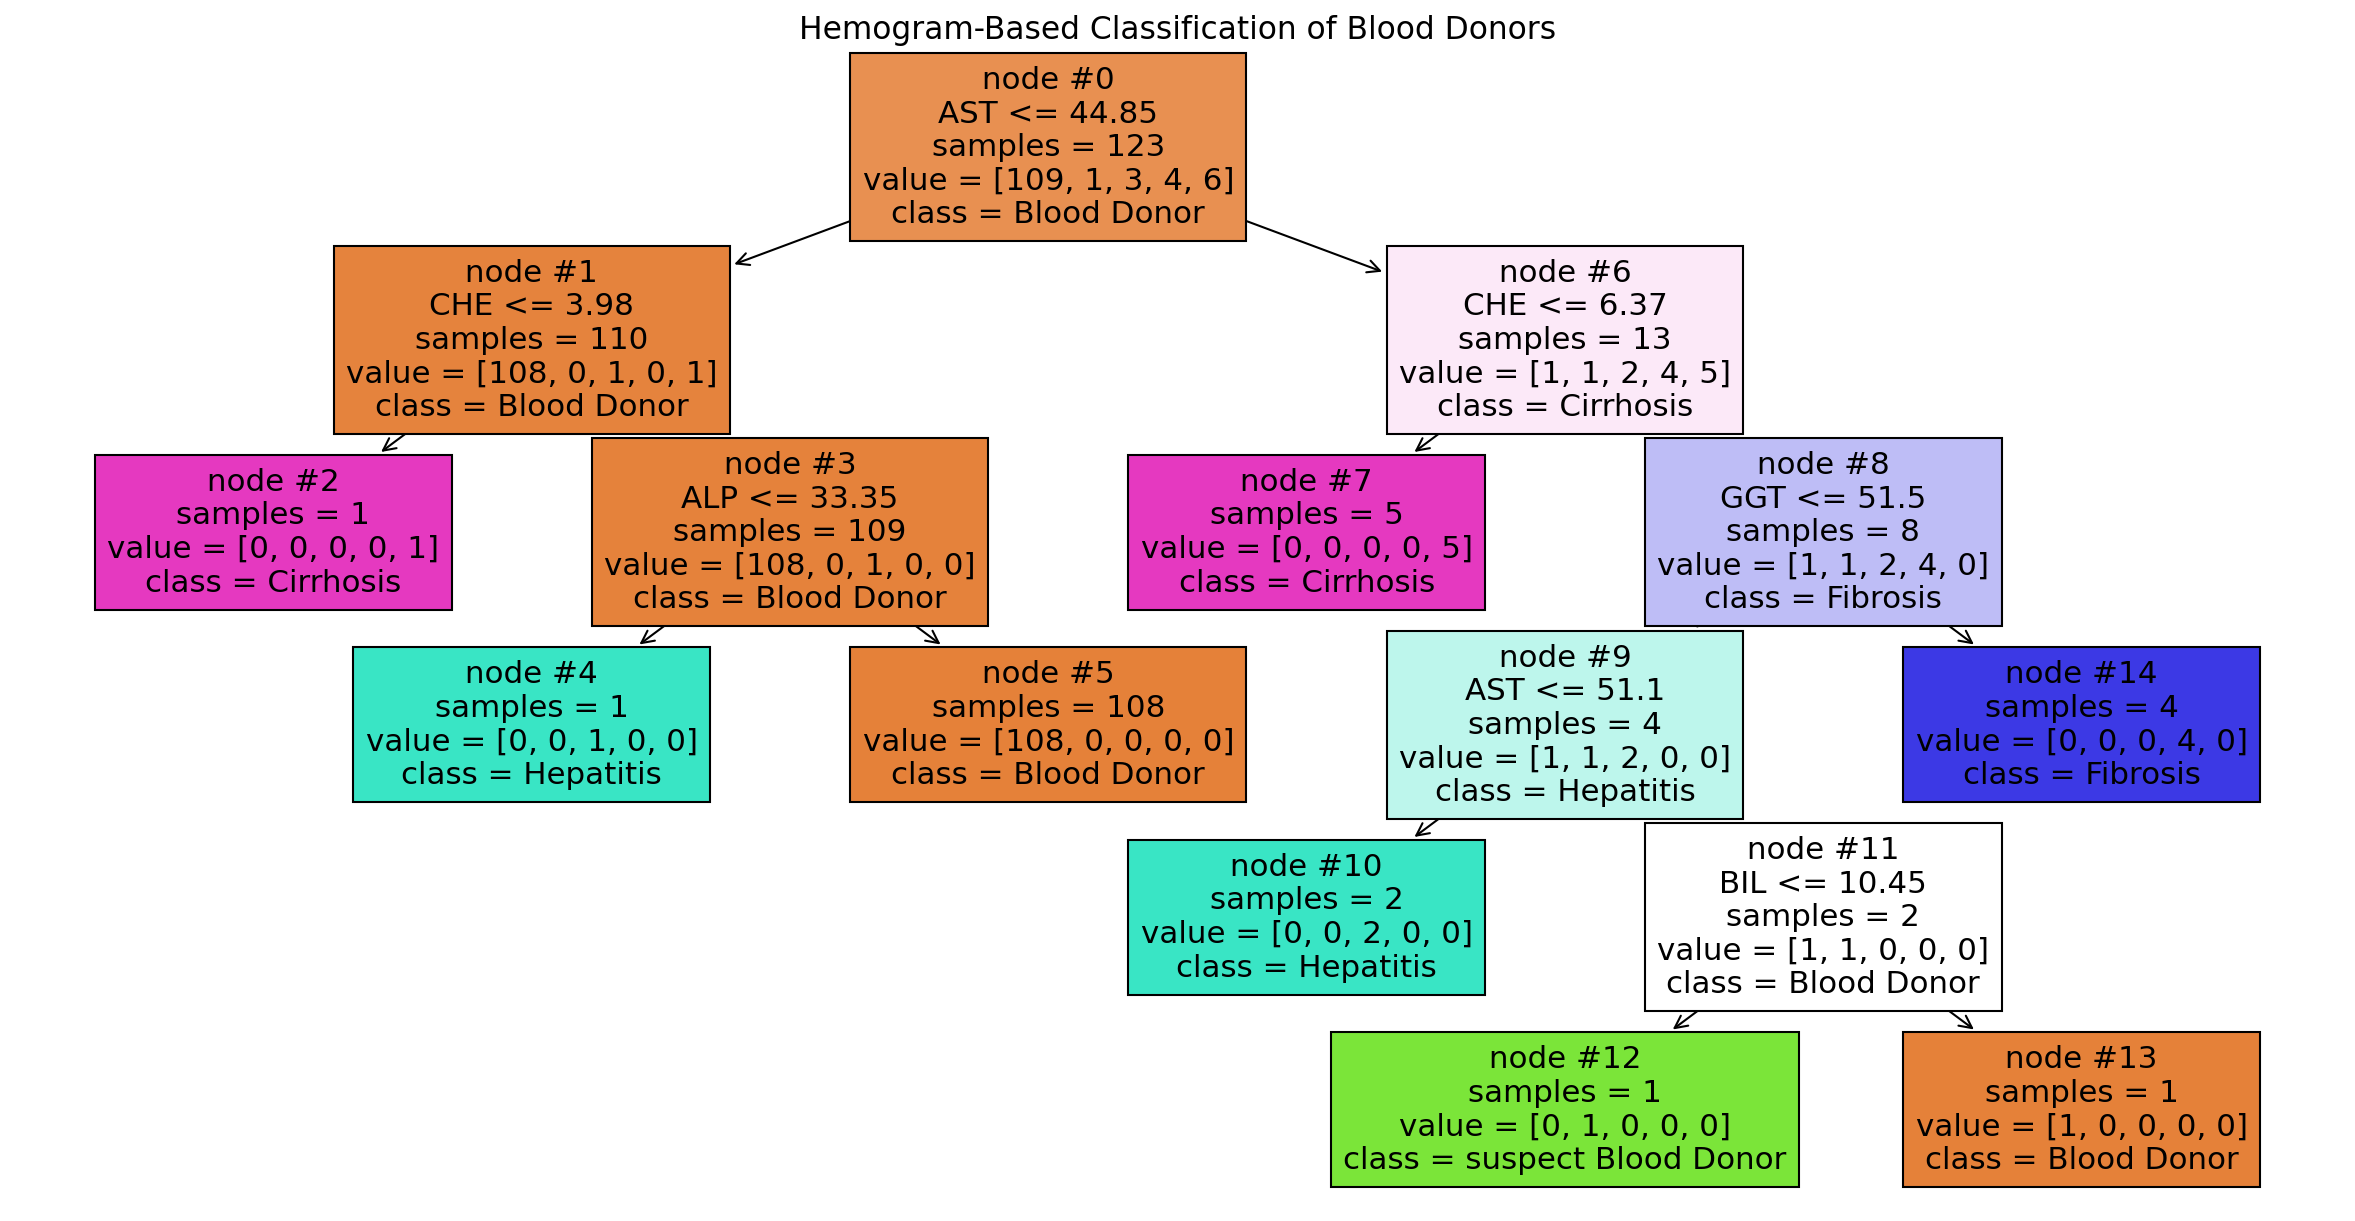

In [19]:
plot_decision_tree(decision_tree=clf, feature_names=list(X.columns), class_names=class_names)

## 4.4 Decision Path

In [20]:
X_test.iloc[3]

Age      62.00
ALB      32.00
ALP     416.60
ALT       5.90
AST     110.30
BIL      50.00
CHE       5.57
CHOL      6.30
CREA     55.70
GGT     650.90
PROT     68.50
Name: 611, dtype: float64

# Note that warnings are thrown, because our function predicts each patient, so one row at a time, which results in X having no feature name. Due to the fact that we generate a few samples we can garantie the right oder of the features put into our pipeline 

In [21]:
sample = X_test.iloc[3:6, :]

In [22]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #plot_decision_tree(decision_tree=clf, feature_names=list(X.columns), class_names=class_names)
    for index, row in sample.iterrows():
        print("Predicted output for Patient with index:", index)
        print(row)
        sample_2d = row.values.reshape(1,-1)
        explain_prediction(clf, sample_2d, class_names)

Predicted output for Patient with index: 611
Age      62.00
ALB      32.00
ALP     416.60
ALT       5.90
AST     110.30
BIL      50.00
CHE       5.57
CHOL      6.30
CREA     55.70
GGT     650.90
PROT     68.50
Name: 611, dtype: float64
Predicted Class: Cirrhosis
Path taken: Nodes 0, 6 and 7
Predicted output for Patient with index: 133
Age     44.00
ALB     35.50
ALP     81.70
ALT     27.50
AST     29.50
BIL      6.40
CHE      8.81
CHOL     6.65
CREA    83.00
GGT     24.10
PROT    68.00
Name: 133, dtype: float64
Predicted Class: Blood Donor
Path taken: Nodes 0, 1, 3 and 5
Predicted output for Patient with index: 603
Age      61.00
ALB      39.00
ALP     102.90
ALT      27.30
AST     143.20
BIL      15.00
CHE       5.38
CHOL      4.88
CREA     72.30
GGT     400.30
PROT     73.40
Name: 603, dtype: float64
Predicted Class: Cirrhosis
Path taken: Nodes 0, 6 and 7


# 5. Anomaly Detection (TODO)

In [23]:
# seperate features and label
X = df.drop(columns='Category')
y = df['Category']
# numerically encode labels whilst storing their names
label_encoder = LabelEncoder()


In [24]:
for index in sample.index:
    print(index)
    print(sample.loc[index,:])

611
Age      62.00
ALB      32.00
ALP     416.60
ALT       5.90
AST     110.30
BIL      50.00
CHE       5.57
CHOL      6.30
CREA     55.70
GGT     650.90
PROT     68.50
Name: 611, dtype: float64
133
Age     44.00
ALB     35.50
ALP     81.70
ALT     27.50
AST     29.50
BIL      6.40
CHE      8.81
CHOL     6.65
CREA    83.00
GGT     24.10
PROT    68.00
Name: 133, dtype: float64
603
Age      61.00
ALB      39.00
ALP     102.90
ALT      27.30
AST     143.20
BIL      15.00
CHE       5.38
CHOL      4.88
CREA     72.30
GGT     400.30
PROT     73.40
Name: 603, dtype: float64


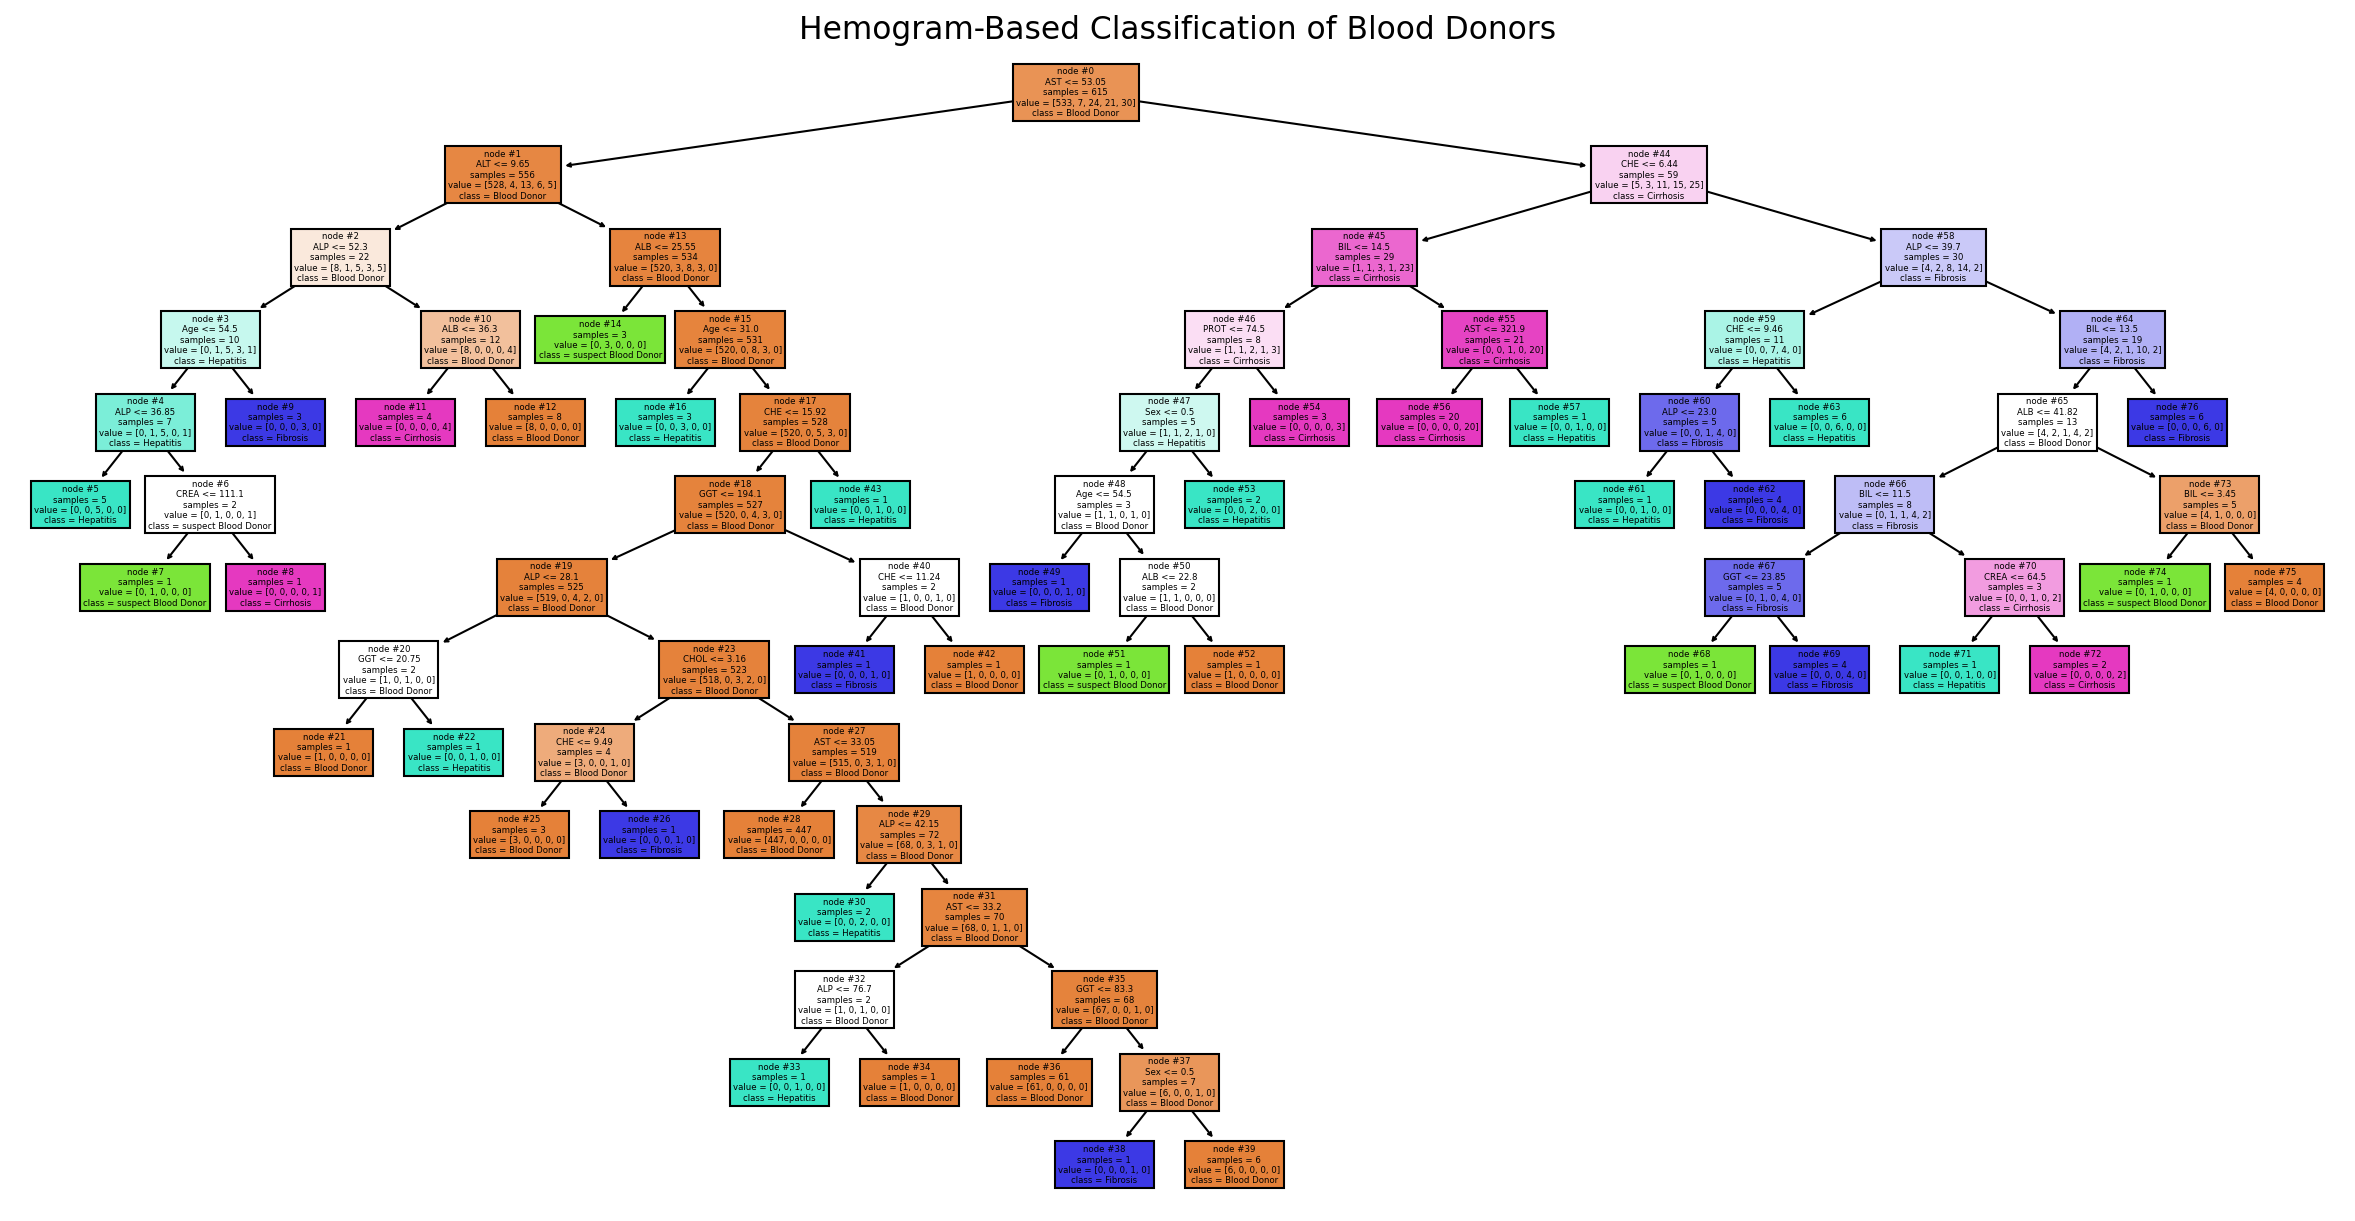

Predicted output for Patient with index: 4
Predicted Class: Blood Donor
Path taken: Nodes 0, 1, 13, 15, 17, 18, 19, 23, 27 and 28
[1] 

Predicted output for Patient with index: 51
Predicted Class: Blood Donor
Path taken: Nodes 0, 1, 13, 15, 17, 18, 19, 23, 27 and 28
[1] 

Predicted output for Patient with index: 601
Predicted Class: Cirrhosis
Path taken: Nodes 0, 44, 45, 55 and 56
[-1] 



Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer',
                                                  IterativeImputer(estimator=KNeighborsRegressor()),
                                                  ['Age', 'ALB', 'ALP', 'ALT',
                                                   'AST', 'BIL', 'CHE', 'CHOL',
                                                   'CREA', 'GGT', 'PROT'])],
                                   verbose_feature_names_out=False)),
                ('combiner', Combiner())])

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer
import pandas as pd 
import warnings

# read the data
df = pd.read_csv('./data/hcvdat33_Complete.csv', index_col=0) # use first col as index
label_encoder_sex = LabelEncoder()
df['Sex'] = label_encoder_sex.fit_transform(df['Sex'])

X = df.drop(columns=["Category"])
y = df["Category"]

y_copy = y.copy()

label_encoder_names = LabelEncoder() 
y = label_encoder_names.fit_transform(y)
class_names = label_encoder_names.classes_
class_names = [class_name.split('=')[1] for class_name in class_names]
class_names = list(map(str, class_names)) # convert to list of strings

numerical_columns = ["Age","ALB","ALP","ALT","AST","BIL","CHE","CHOL","CREA","GGT","PROT"]

knn = KNeighborsRegressor(n_neighbors=5)
iterative_imputer = IterativeImputer(estimator=knn, add_indicator=False)
imputer = ColumnTransformer([("imputer", iterative_imputer, numerical_columns)],
                            remainder="passthrough",
                            verbose_feature_names_out=False).set_output(transform="pandas")

sample = X.iloc[[3,50,600], :]

class Combiner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dt = DecisionTreeClassifier()
        self.iso = IsolationForest()

    def scalePCAprep (self,X):
        self.rs = RobustScaler()
        scaledData= self.rs.fit_transform(X)
        self.pca = PCA(n_components=2)
        pcaData= self.pca.fit_transform(scaledData)
        return pcaData

    def scalePCAuse (self, X):
        scaledData= self.rs.fit_transform(X)
        pcaData= self.pca.transform(scaledData)
        return pcaData

    def fit(self, X, y=None):
        self.dt.fit(X, y)
        # Get only data from Blood donors
        ind = y_copy[y_copy=="0=Blood Donor"].index
        donorX=X.iloc[ind,:]
        prepedData= self.scalePCAprep(donorX)
        
        self.iso.fit(prepedData)

    def transform(self, sample):
        prepedData = self.scalePCAuse(sample)

        plot_decision_tree(self.dt, feature_names=list(sample.columns), class_names=class_names)

        for index in sample.index:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                print("Predicted output for Patient with index:", index)
                row_dt = sample.loc[index,:]
                sample_2d_dt = row_dt.values.reshape(1,-1)
                explain_prediction(self.dt, sample_2d_dt, class_names)
                
                row_iso = prepedData.loc[index,:]
                sample_2d_iso = row_iso.values.reshape(1,-1)
                pred_iso = self.iso.predict(sample_2d_iso)
                print(pred_iso, "\n")
        

pipeline = Pipeline([("imputer", imputer),
                    #("estimator", estimator),
                    ('combiner', Combiner())
                    ])

pipeline.fit(X,y)
pipeline.transform(sample) #TODO Self gen data
pipeline

In [26]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer

# Assuming your data is in a DataFrame 'X' and target variable in 'y'

# Define columns for imputation
imputation_columns = [...]  # Columns to impute missing values

# Create transformers for imputation
imputer = KNNImputer(n_neighbors=5, weights='distance') # initialize the imputer

# Create a column transformer for imputation
imputation_transformer = ColumnTransformer(
    transformers=[
        ('impute', imputer)
    ])

# Create a pipeline for the decision tree branch
dt_pipeline = Pipeline([
    ('imputation', imputation_transformer),
    ('decision_tree', DecisionTreeClassifier())]
)

# Define columns for scaling, PCA, and isolation forest
scaling_columns = [...]  # Columns to scale

# Create transformers for scaling, PCA, and isolation forest
scaler = RobustScaler()
pca = PCA(n_components=3)  # Adjust the number of components as needed
isolation_forest = IsolationForest(contamination=0.1)  # Adjust contamination as needed -> keine anomaly mittraineren

# Create a column transformer for scaling, PCA, and isolation forest
scaling_pca_iso_transformer = ColumnTransformer(
    transformers=[
        ('scale', scaler),
        ('pca', pca),
        ('isolate', isolation_forest)
    ])

# Create a pipeline for the robust scaling, PCA, and isolation forest branch
rs_pca_iso_pipeline = make_pipeline([
    ('imputation', imputation_transformer),
    ('scaling_pca_iso', scaling_pca_iso_transformer)]
)

# Combine the two branches into a FeatureUnion
full_pipeline = FeatureUnion([
    ('dt_branch', dt_pipeline),
    ('rs_pca_iso_branch', rs_pca_iso_pipeline)
])

# Fit the combined pipeline on your data
full_pipeline.fit(X_train, y_train)

# Make predictions (predictions from both branches)
#predictions = full_pipeline.transform(X_test)

TypeError: All estimators should implement fit and transform. 'Pipeline(steps=[('imputation',
                 ColumnTransformer(transformers=[('impute',
                                                  KNNImputer(weights='distance'))])),
                ('decision_tree', DecisionTreeClassifier())])' (type <class 'sklearn.pipeline.Pipeline'>) doesn't

# Neue Klasse (Dtc) die BaseEstimator, (drauf achte, dass es nur die Normalfälle sind)

# 6. Final Model (TODO)

## 6.1 Combine Decision Tree and Anomaly Detection (TODO)

# TODO for pipeline
Kombinieren und dann gucken, dass Anomaly, Class und decision path ein output sind

In [ ]:
anomalies = generate_anomalies(30)
anomalies

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1=Hepatitis,60,f,77,348,259,173,196,14,10,564,189,42
1,1=Hepatitis,55,f,66,226,229,141,160,13,9,317,451,41
2,0s=suspect Blood Donor,70,f,72,153,127,138,75,15,7,534,158,60
3,0s=suspect Blood Donor,55,f,79,213,231,162,148,15,10,463,396,8
4,1=Hepatitis,66,m,70,234,111,122,90,13,7,673,536,64
5,0s=suspect Blood Donor,60,f,67,369,167,193,112,10,9,513,524,40
6,0s=suspect Blood Donor,66,m,74,193,148,183,74,12,7,548,458,65
7,2=Fibrosis,65,f,76,196,198,126,99,10,10,581,450,15
8,2=Fibrosis,60,f,65,384,129,124,192,14,10,784,587,59
9,0s=suspect Blood Donor,59,m,71,384,177,147,200,12,10,546,477,59
